In [2]:
import MySQLdb
import sshtunnel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from scipy.stats import pearsonr
from ast import literal_eval
import matplotlib.pyplot as plt

In [4]:
sshtunnel.SSH_TIMEOUT = 5.0
sshtunnel.TUNNEL_TIMEOUT = 5.0

with sshtunnel.SSHTunnelForwarder(
    ('ssh.pythonanywhere.com'),
    ssh_username='Grawi', ssh_password='midgeq-xikFah-gukpu7',
    remote_bind_address=('Grawi.mysql.pythonanywhere-services.com', 3306)
) as tunnel:
    print("Successfully connected to Pythonanywhere")
    connection = MySQLdb.connect(
        user='Grawi',
        passwd='david2202087',
        host='127.0.0.1', port=tunnel.local_bind_port,
        db='Grawi$Interactive_quiz_database',
    )
    # Do stuff
    print("Successfully connected to database")
    
    try:
        cursor = connection.cursor()
        query = "SELECT * FROM pilot_1;"
        df = pd.read_sql(query, connection)
        print(f"Data read finished, length {len(df)}")
    except Exception as e:
        print("Error:", e)
    
    finally:
        # Close the cursor and connection
        cursor.close()
        connection.close()

Successfully connected to Pythonanywhere
Successfully connected to database
Data read finished, length 300


In [9]:
connect_data_path = 'connect_data/pilot_1.csv'
connect_df = pd.read_csv(connect_data_path)

connect_ideology_mapping = {
    'Conservative': 2,
    'Liberal': -2,
    'Somewhat Liberal': -1,
    'Somewhat Conservative': 1,
    'Moderate': 0
}

connect_df['Political Ideology'] = connect_df['Political Ideology'].map(connect_ideology_mapping)

df = df[df['submit_time'] >= '2023-09-01']
df['connect_ideology'] = None
row_index_to_drop = []      # exists in database but not on connect platform
for index, row in df.iterrows():
    id = row['participantId']
    connect_search_result = connect_df[connect_df['ParticipantId'] == id]
    connect_search_result.reset_index(drop=True, inplace=True)
    if len(connect_search_result):
        df.at[index, 'connect_ideology'] = connect_search_result.at[connect_search_result.index.tolist()[0], 'Political Ideology']
    else:
        row_index_to_drop.append(index)
df['connect_ideology'] = df['connect_ideology'].astype(int)
print("Number of rows to drop:", len(row_index_to_drop))
df.head()

Number of rows to drop: 0


,participantId,assignmentId,projectId,attention_passed,total_time,identity_choices,ideologies,ideology_answers,additional_answers,bot_detected,submit_time,reason,connect_ideology
1,0163260E3DF74A1E8CA46ADD5D792370,6632c41b-6b19-49ee-9649-b6a09a63afba,1d45ed72-1853-4a1d-8322-e4ece3465ad8,1,242.366,"[[1, 3], [3, 2], [11, 5]]","[-1, 0, 2]","[{""answers"": [0, 0, 0], ""time_to_answer"": [5.8...","[[1, 0, -0.9], [2, 2], [-1, 1]]",66.0,2023-10-10 02:18:13,,0
6,03DE8461A90E4AE08F72F2258BBA7832,40c42ab6-5f1c-4676-9fed-9b67d8938ad6,b85bb99e-4e46-48e8-8c4b-d6ee15a5b95c,1,260.008,"[[18, 5], [8, 4], [2, 1]]","[-1, 0, 1]","[{""answers"": [1, 1, 1], ""time_to_answer"": [4.5...","[[2, -1.8, -2], [-2, 1.5], [-0.5, 1.8]]",52.0,2023-09-05 09:36:39,,-2
7,0534356469D74809A75902C69E6E0BD6,22aebcd8-02c9-4930-af15-c3840f2c2811,b85bb99e-4e46-48e8-8c4b-d6ee15a5b95c,1,303.092,"[[11, 4], [3, 5], [19, 0]]","[-2, 0, 1]","[{""answers"": [1, 0, 0], ""time_to_answer"": [9.9...","[[1.1, -1, -1], [-1, 2], [-1.7, 2]]",51.0,2023-09-05 09:23:08,,0
10,08384FE1523E41528B20E2C37BE811AC,36f5ce4b-7956-418a-b00e-34720cc42baa,b85bb99e-4e46-48e8-8c4b-d6ee15a5b95c,1,251.052,"[[9, 2], [11, 5], [5, 1]]","[-2, 0, 1]","[{""answers"": [0, 1, 1], ""time_to_answer"": [5.6...","[[2, -2, -0.9], [0, 1.5], [-1.1, 1.5]]",33.0,2023-09-05 09:24:11,,-2
15,0AFC8075954343C9939BEAAD2E48C7DE,5873bb2a-ec55-4c70-b8c7-d097601c5ab1,1d45ed72-1853-4a1d-8322-e4ece3465ad8,1,403.308,"[[19, 4], [3, 2], [13, 3]]","[-1, 0, 1]","[{""answers"": [0, 0, 0], ""time_to_answer"": [9.7...","[[-0.4, -0.7, -0.3], [1.2, 1], [1, 1]]",33.0,2023-10-10 02:26:52,"real people are unpredictable, this was to smo...",-1


# Analysis Process
1. Figure out when the abortion statement was changed
2. Mapping: participantId -> number of liberal answers for 6 not extremely stated questions
3. Divide them into 5 ideology groups according to the number
4. Verify each part for the rest 4 extremely stated questions, should observe a relative difference for each group
5. Find the 'common' example for each part

## Do calculations for each participant

In [10]:
df_attention_passed = df[df['attention_passed'] == 1]
data = df[['participantId', 'ideology_answers', 'submit_time', 'additional_answers', 'connect_ideology']]
data.set_index('participantId', inplace=True)
data['ideology_answers'] = data['ideology_answers'].apply(literal_eval)
data['additional_answers'] = data['additional_answers'].apply(literal_eval)

# whether the data is submitted after changing human index or not
change_time = pd.Timestamp('2023-08-08')
def is_after_change(submit_time):
    return not pd.isna(submit_time) and submit_time >= change_time
data['after_change'] = data['submit_time'].apply(is_after_change)
data.drop(['submit_time'], axis=1, inplace=True)
print(data.groupby('after_change').size())

# get reported ideology
def get_human_index(after_change):
    return 1 if after_change else 0

def get_reported_ideology(ideologies, after_change):
    if after_change:
        return ideologies[get_human_index(after_change)]
    else:
        return ideologies[get_human_index(after_change)] / 3 * 2

data['reported_ideology'] = data.apply(lambda row: get_reported_ideology(row['additional_answers'][0], row['after_change']), axis=1)
data.drop(['additional_answers'], axis=1, inplace=True)
data.head()

after_change
True    101
dtype: int64


,ideology_answers,connect_ideology,after_change,reported_ideology
participantId,,,,
0163260E3DF74A1E8CA46ADD5D792370,"[{'answers': [0, 0, 0], 'time_to_answer': [5.8...",0,True,0.0
03DE8461A90E4AE08F72F2258BBA7832,"[{'answers': [1, 1, 1], 'time_to_answer': [4.5...",-2,True,-1.8
0534356469D74809A75902C69E6E0BD6,"[{'answers': [1, 0, 0], 'time_to_answer': [9.9...",0,True,-1.0
08384FE1523E41528B20E2C37BE811AC,"[{'answers': [0, 1, 1], 'time_to_answer': [5.6...",-2,True,-2.0
0AFC8075954343C9939BEAAD2E48C7DE,"[{'answers': [0, 0, 0], 'time_to_answer': [9.7...",-1,True,-0.7


### Explode table for each question

In [11]:
exploded_data = data.explode('ideology_answers')
exploded_data['index'] = exploded_data.apply(lambda row: row['ideology_answers']['idx_of_question'], axis=1)
exploded_data['answer'] = exploded_data.apply(lambda row: row['ideology_answers']['answers'][get_human_index(row['after_change'])], axis=1)
each_question = exploded_data.drop(['ideology_answers'], axis=1)
each_question.head()

,connect_ideology,after_change,reported_ideology,index,answer
participantId,,,,,
0163260E3DF74A1E8CA46ADD5D792370,0,True,0.0,0,0
0163260E3DF74A1E8CA46ADD5D792370,0,True,0.0,5,0
0163260E3DF74A1E8CA46ADD5D792370,0,True,0.0,1,0
0163260E3DF74A1E8CA46ADD5D792370,0,True,0.0,7,0
0163260E3DF74A1E8CA46ADD5D792370,0,True,0.0,3,0


### Get string representation of all answers

In [12]:
def get_ans_str(row, target_index=list(range(10))):
    ret = [0] * len(target_index)
    participant_index = get_human_index(row['after_change'])
    for answer_wrap in row['ideology_answers']:
        index = answer_wrap['idx_of_question']
        if index in target_index:
            ret[target_index.index(index)] = answer_wrap['answers'][participant_index]
    return ret

data['answer_string'] = data.apply(get_ans_str, axis=1)
data.head()

,ideology_answers,connect_ideology,after_change,reported_ideology,answer_string
participantId,,,,,
0163260E3DF74A1E8CA46ADD5D792370,"[{'answers': [0, 0, 0], 'time_to_answer': [5.8...",0,True,0.0,"[0, 0, 1, 0, 1, 0, 1, 0, 0, 1]"
03DE8461A90E4AE08F72F2258BBA7832,"[{'answers': [1, 1, 1], 'time_to_answer': [4.5...",-2,True,-1.8,"[0, 0, 1, 1, 1, 0, 1, 0, 0, 1]"
0534356469D74809A75902C69E6E0BD6,"[{'answers': [1, 0, 0], 'time_to_answer': [9.9...",0,True,-1.0,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 1]"
08384FE1523E41528B20E2C37BE811AC,"[{'answers': [0, 1, 1], 'time_to_answer': [5.6...",-2,True,-2.0,"[0, 0, 1, 0, 1, 0, 1, 0, 0, 1]"
0AFC8075954343C9939BEAAD2E48C7DE,"[{'answers': [0, 0, 0], 'time_to_answer': [9.7...",-1,True,-0.7,"[0, 0, 1, 1, 1, 0, 1, 1, 0, 1]"


In [13]:
from phase_1_statements import phase_1_statements

def is_liberal_answer(row):
    index = row['index']
    answer = row['answer']
    info = phase_1_statements[index]
    assert info['type'] != 'preference', "Cannot get the liberal answer for question of preference"
    return info['left_attitude'] and answer == 0 or not info['left_attitude'] and answer == 1

def is_extreme_liberal_answer(row):
    info = phase_1_statements[row['index']]
    return info['extreme'] and row['answer'] == 0 and info['left_attitude']

def is_extreme_conservative_answer(row):
    info = phase_1_statements[row['index']]
    return row['index'] != 9 and info['extreme'] and row['answer'] == 0 and not info['left_attitude']

def get_liberal_weight(row):
    index = row['index']
    answer = row['answer']
    info = phase_1_statements[index]
    assert info['type'] != 'preference', "Cannot get the liberal answer for question of preference"
    if index == 9:
        return 0
    if not info['extreme']:
        if info['left_attitude'] and answer == 0 or not info['left_attitude'] and answer == 1:
            return 1
        else:
            return -1
    else:
        if info['left_attitude']:
            if answer == 0:
                return 2
            else:
                return -0.5
        else:
            if answer == 0:
                return -2
            else:
                return 0.5

each_question['question_liberal_weight'] = each_question.apply(get_liberal_weight, axis=1)
each_question['is_liberal'] = each_question.apply(is_liberal_answer, axis=1)
# each_question['is_extreme_liberal'] = each_question.apply(is_extreme_liberal_answer, axis=1)
# each_question['is_extreme_conservative'] = each_question.apply(is_extreme_conservative_answer, axis=1)
each_question.head()

,connect_ideology,after_change,reported_ideology,index,answer,question_liberal_weight,is_liberal
participantId,,,,,,,
0163260E3DF74A1E8CA46ADD5D792370,0,True,0.0,0,0,1.0,True
0163260E3DF74A1E8CA46ADD5D792370,0,True,0.0,5,0,1.0,True
0163260E3DF74A1E8CA46ADD5D792370,0,True,0.0,1,0,1.0,True
0163260E3DF74A1E8CA46ADD5D792370,0,True,0.0,7,0,2.0,True
0163260E3DF74A1E8CA46ADD5D792370,0,True,0.0,3,0,1.0,True


### Calculate
1. liberal weight
2. number of liberal answers

In [14]:
num_of_liberal_ans = each_question.groupby('participantId')['is_liberal'].sum()
data['num_of_liberal_ans'] = num_of_liberal_ans
# num_of_extreme_liberal_ans = each_question.groupby('participantId')['is_extreme_liberal'].sum()
# data['num_of_extreme_liberal_ans'] = num_of_extreme_liberal_ans
# num_of_extreme_conservative_ans = each_question.groupby('participantId')['is_extreme_conservative'].sum()
# data['num_of_extreme_conservative_ans'] = num_of_extreme_conservative_ans
# correlation = data['reported_ideology'].corr(data['num_of_liberal_ans'])
# print(f"Correlation between reported ideology and number of liberal answers is {correlation: .3f}")

liberal_weight = each_question.groupby('participantId')['question_liberal_weight'].sum()
data['liberal_weight'] = liberal_weight

data.drop(['ideology_answers', 'after_change'], axis=1, inplace=True)
correlation_reported = data['reported_ideology'].corr(data['liberal_weight'])
correlation_connect = data['connect_ideology'].corr(data['liberal_weight'])
print(f"Correlation between reported ideology and liberal weight is {correlation_reported: .3f}")
print(f"Correlation between connect ideology and liberal weight is {correlation_connect: .3f}")
data.head()

Correlation between reported ideology and liberal weight is -0.717
Correlation between connect ideology and liberal weight is -0.692


,connect_ideology,reported_ideology,answer_string,num_of_liberal_ans,liberal_weight
participantId,,,,,
0163260E3DF74A1E8CA46ADD5D792370,0,0.0,"[0, 0, 1, 0, 1, 0, 1, 0, 0, 1]",10,10.5
03DE8461A90E4AE08F72F2258BBA7832,-2,-1.8,"[0, 0, 1, 1, 1, 0, 1, 0, 0, 1]",9,8.5
0534356469D74809A75902C69E6E0BD6,0,-1.0,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 1]",6,1.5
08384FE1523E41528B20E2C37BE811AC,-2,-2.0,"[0, 0, 1, 0, 1, 0, 1, 0, 0, 1]",10,10.5
0AFC8075954343C9939BEAAD2E48C7DE,-1,-0.7,"[0, 0, 1, 1, 1, 0, 1, 1, 0, 1]",8,6.0


### Get weight / count distribution

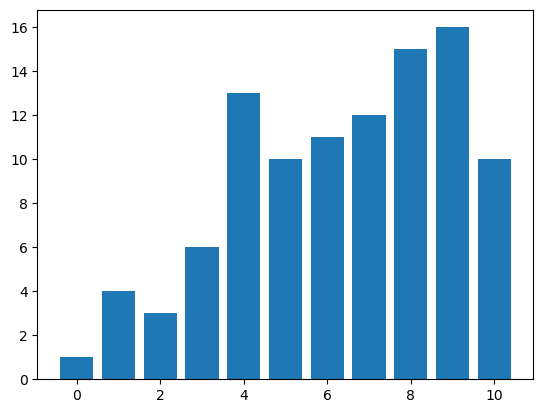

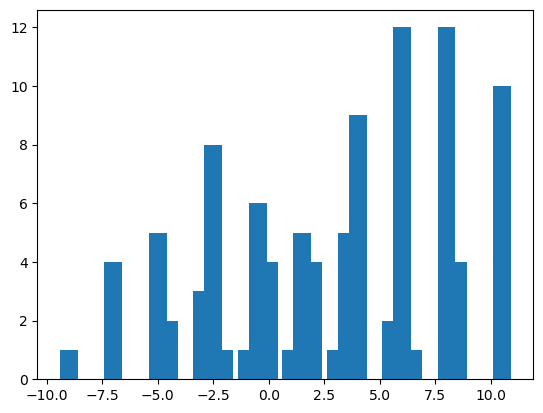

In [15]:
liberal_ans_cnt = data['num_of_liberal_ans'].value_counts()
plt.bar(height=[liberal_ans_cnt[i] for i in range(11)], x=list(range(11)))
plt.show()

liberal_weight_counts = data['liberal_weight'].value_counts()
liberal_weight_index_list = sorted(liberal_weight_counts.index.tolist())
plt.bar(height=[liberal_weight_counts[index] for index in liberal_weight_index_list], x=liberal_weight_index_list)
plt.show()

## Group participants according to a given benchmark

In [16]:
chosen_ranges = [(0, 0.1), (0.3, 0.4), (0.6, 0.7), (0.9, 0.999)]
num = len(data)
data.head()

,connect_ideology,reported_ideology,answer_string,num_of_liberal_ans,liberal_weight
participantId,,,,,
0163260E3DF74A1E8CA46ADD5D792370,0,0.0,"[0, 0, 1, 0, 1, 0, 1, 0, 0, 1]",10,10.5
03DE8461A90E4AE08F72F2258BBA7832,-2,-1.8,"[0, 0, 1, 1, 1, 0, 1, 0, 0, 1]",9,8.5
0534356469D74809A75902C69E6E0BD6,0,-1.0,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 1]",6,1.5
08384FE1523E41528B20E2C37BE811AC,-2,-2.0,"[0, 0, 1, 0, 1, 0, 1, 0, 0, 1]",10,10.5
0AFC8075954343C9939BEAAD2E48C7DE,-1,-0.7,"[0, 0, 1, 1, 1, 0, 1, 1, 0, 1]",8,6.0


### 1. Use number of liberal answers

In [17]:
num_of_liberal_ans = sorted(data['num_of_liberal_ans'].tolist())
for each_range in chosen_ranges:
    print(f"For range {each_range}, start: {num_of_liberal_ans[int(num * each_range[0])]}, end: {num_of_liberal_ans[int(num * each_range[1])]}")

For range (0, 0.1), start: 0, end: 3
For range (0.3, 0.4), start: 5, end: 6
For range (0.6, 0.7), start: 8, end: 8
For range (0.9, 0.999), start: 9, end: 10


In [18]:
def get_ideology_from_num(num):
    if num == 0 or num == 1:
        return -2
    elif num == 4:
        return -1
    elif num == 8:
        return 1
    elif num == 10:
        return 2
    else:
        return 0

data['ideology_from_num'] = data['num_of_liberal_ans'].map(get_ideology_from_num)
data.head()

,connect_ideology,reported_ideology,answer_string,num_of_liberal_ans,liberal_weight,ideology_from_num
participantId,,,,,,
0163260E3DF74A1E8CA46ADD5D792370,0,0.0,"[0, 0, 1, 0, 1, 0, 1, 0, 0, 1]",10,10.5,2
03DE8461A90E4AE08F72F2258BBA7832,-2,-1.8,"[0, 0, 1, 1, 1, 0, 1, 0, 0, 1]",9,8.5,0
0534356469D74809A75902C69E6E0BD6,0,-1.0,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 1]",6,1.5,0
08384FE1523E41528B20E2C37BE811AC,-2,-2.0,"[0, 0, 1, 0, 1, 0, 1, 0, 0, 1]",10,10.5,2
0AFC8075954343C9939BEAAD2E48C7DE,-1,-0.7,"[0, 0, 1, 1, 1, 0, 1, 1, 0, 1]",8,6.0,1


### 2. Use calculated liberal weight

In [19]:
liberal_weight = sorted(data['liberal_weight'].tolist())
for each_range in chosen_ranges:
    print(f"For range {each_range}, start: {liberal_weight[int(num * each_range[0])]}, end: {liberal_weight[int(num * each_range[1])]}")

For range (0, 0.1), start: -9.0, end: -4.5
For range (0.3, 0.4), start: -0.5, end: 1.5
For range (0.6, 0.7), start: 5.5, end: 6.0
For range (0.9, 0.999), start: 8.5, end: 10.5


In [20]:
def get_ideology_from_weight(weight):
    if weight >= -9 and weight <= -5:
        return -2
    elif weight >= 1.5 and weight <= 4:
        return -1
    elif weight >= 8.5 and weight <= 9.5:
        return 1
    elif weight >= 10 and weight <= 10.5:
        return 2
    else:
        return 0

data['ideology_from_weight'] = data['liberal_weight'].map(get_ideology_from_weight)
data.head()

,connect_ideology,reported_ideology,answer_string,num_of_liberal_ans,liberal_weight,ideology_from_num,ideology_from_weight
participantId,,,,,,,
0163260E3DF74A1E8CA46ADD5D792370,0,0.0,"[0, 0, 1, 0, 1, 0, 1, 0, 0, 1]",10,10.5,2,2
03DE8461A90E4AE08F72F2258BBA7832,-2,-1.8,"[0, 0, 1, 1, 1, 0, 1, 0, 0, 1]",9,8.5,0,1
0534356469D74809A75902C69E6E0BD6,0,-1.0,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 1]",6,1.5,0,-1
08384FE1523E41528B20E2C37BE811AC,-2,-2.0,"[0, 0, 1, 0, 1, 0, 1, 0, 0, 1]",10,10.5,2,2
0AFC8075954343C9939BEAAD2E48C7DE,-1,-0.7,"[0, 0, 1, 1, 1, 0, 1, 1, 0, 1]",8,6.0,1,0


## Calculate average answer for each question in each group

In [21]:
each_question['ideology_from_num'] = data['ideology_from_num']
for question_ideology in [-2, -1, 1, 2]:
    print(f"For ideology {question_ideology}")
    each_question_given_ideology = each_question[each_question['ideology_from_num'] == question_ideology]
    print(each_question_given_ideology.groupby('index')['answer'].mean().tolist())

For ideology -2
[0.8, 1.0, 0.2, 1.0, 0.2, 0.8, 0.0, 1.0, 1.0, 0.0]
For ideology -1
[0.5384615384615384, 0.6923076923076923, 0.46153846153846156, 0.9230769230769231, 0.46153846153846156, 0.46153846153846156, 0.23076923076923078, 0.9230769230769231, 0.38461538461538464, 0.7692307692307693]
For ideology 1
[0.0, 0.06666666666666667, 0.6, 0.4, 1.0, 0.06666666666666667, 0.8, 0.8666666666666667, 0.0, 1.0]
For ideology 2
[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0]


In [22]:
each_question['ideology_from_weight'] = data['ideology_from_weight']
for question_ideology in [-2, -1, 1, 2]:
    print(f"For ideology {question_ideology}")
    each_question_given_ideology = each_question[each_question['ideology_from_weight'] == question_ideology]
    print(each_question_given_ideology.groupby('index')['answer'].mean())

For ideology -2
index
0    0.8
1    0.7
2    0.2
3    1.0
4    0.3
5    0.6
6    0.0
7    1.0
8    1.0
9    0.3
Name: answer, dtype: float64
For ideology -1
index
0    0.250000
1    0.250000
2    0.500000
3    0.583333
4    0.833333
5    0.125000
6    0.583333
7    0.833333
8    0.250000
9    0.791667
Name: answer, dtype: float64
For ideology 1
index
0    0.0
1    0.0
2    0.5
3    0.5
4    1.0
5    0.0
6    1.0
7    0.0
8    0.0
9    1.0
Name: answer, dtype: float64
For ideology 2
index
0    0.0
1    0.0
2    1.0
3    0.0
4    1.0
5    0.0
6    1.0
7    0.0
8    0.0
9    1.0
Name: answer, dtype: float64


In [23]:
each_question_somewhat_conservative = each_question[each_question['ideology_from_weight'] == -1]
average_answer_somewhat_conservative = each_question_somewhat_conservative.groupby('index')['answer'].mean()

each_question_somewhat_liberal = each_question[each_question['ideology_from_weight'] == 1]
average_answer_somewhat_liberal = each_question_somewhat_liberal.groupby('index')['answer'].mean()
sum(abs(average_answer_somewhat_conservative - average_answer_somewhat_liberal))

2.5833333333333335

In [25]:
each_question_somewhat_conservative = each_question[each_question['ideology_from_num'] == -1]
average_answer_somewhat_conservative = each_question_somewhat_conservative.groupby('index')['answer'].mean()

each_question_somewhat_liberal = each_question[each_question['ideology_from_num'] == 1]
average_answer_somewhat_liberal = each_question_somewhat_liberal.groupby('index')['answer'].mean()
sum(abs(average_answer_somewhat_conservative - average_answer_somewhat_liberal))

3.9999999999999996